# Algoritmo de Ziggurat

In [41]:
# imports
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

### 1. Generación de	números y variables aleatorias
Describir el algoritmo de Ziggurat para	distribuciones con función de densidad decreciente y compararlo	con	otros métodos para la generación de	valores	de la normal

In [72]:
def gaussian_probability_density_function(x, deviation):
    return np.exp((-1 / 2) * ((x) / (deviation)) ** 2)

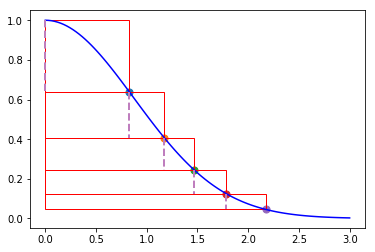

In [73]:
DOMAIN = 3
N = 100
SIZE = 50

domain = np.linspace(0, DOMAIN, N) # return a domain from [0, 1] in 100 parts
deviation = np.std(domain)

divisions = [0, 0.8288, 1.1713, 1.4696, 1.7819, 2.1761]

plt.plot(domain, list( # domain is the x axis and the rest y axis
    map(
        lambda x: gaussian_probability_density_function(x, deviation), 
        domain
    )
), color = 'b')

currentAxis = plt.gca()
for i in range(1, len(divisions)):
    y = gaussian_probability_density_function(divisions[i], deviation) # calculate its y axis value
    y_prev = gaussian_probability_density_function(divisions[i - 1], deviation) # calculate divisions i - 1 y axis value
    
    plt.scatter(divisions[i], y, s = SIZE) # draw point s is size
    rect = patches.Rectangle((0, y), divisions[i], y_prev - y, linewidth = 1, edgecolor = 'r', fill = None) # draw rectangle
    plt.plot([z[i - 1], z[i - 1]], [y_prev, y], color = '#BF7EBE', linewidth = 2, linestyle = 'dashed')
    
    currentAxis.add_patch(rect) # add rectangle

plt.show()
plt.close()

## Esto es con negrita
Explicaciones